
# Credit Score Classification

---
Referance:
- Web Analytics lecture material from MGS 659
- Best practices from [Feature Engineering + CatBoost Kaggle Notebook](https://www.kaggle.com/code/ratandshetty/feature-engineering-catboost)
  - Label encoding + rare category grouping
  - Binning of multiple numerical features
  - Skewness treatment and log transformation
  - Encoding `Payment_Behaviour` and cleaning outliers


In [ ]:
# !pip install catboost pandas scikit-learn matplotlib seaborn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("train.csv", low_memory=False)
df = df[df["Credit_Score"].notna()]
df["Credit_Score"] = df["Credit_Score"].astype(str)

def clean_column(df, col):
    return pd.to_numeric(df[col].astype(str).str.extract(r'([-]?\d+\.?\d*)')[0], errors='coerce')

columns_to_clean = [
    "Age", "Annual_Income", "Monthly_Inhand_Salary",
    "Num_of_Loan", "Num_of_Delayed_Payment", "Changed_Credit_Limit",
    "Outstanding_Debt", "Amount_invested_monthly", "Monthly_Balance"
]
for col in columns_to_clean:
    df[col] = clean_column(df, col)


In [3]:
drop_cols = ["ID", "Customer_ID", "Name", "SSN", "Month", "Credit_History_Age"]
df = df.drop(columns=drop_cols)

df["Income_per_Loan"] = df["Annual_Income"] / (df["Num_of_Loan"] + 1)
df["Debt_to_Income"] = df["Outstanding_Debt"] / (df["Annual_Income"] + 1)
df["Delay_Rate"] = df["Num_of_Delayed_Payment"] / (df["Num_of_Loan"] + 1)
df["Log_Income"] = np.log1p(df["Annual_Income"])
df["Log_Debt"] = np.log1p(df["Outstanding_Debt"])
df["Age_Bin"] = pd.cut(df["Age"], bins=[0, 25, 35, 45, 55, 65, 120], labels=False)


df["Payment_Behaviour"] = df["Payment_Behaviour"].str.extract(r'([a-zA-Z]+_[a-zA-Z]+)', expand=False).fillna("Unknown")


<ipython-input-11-b4286dfeb580>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.values, y=missing_values.index, palette="viridis")


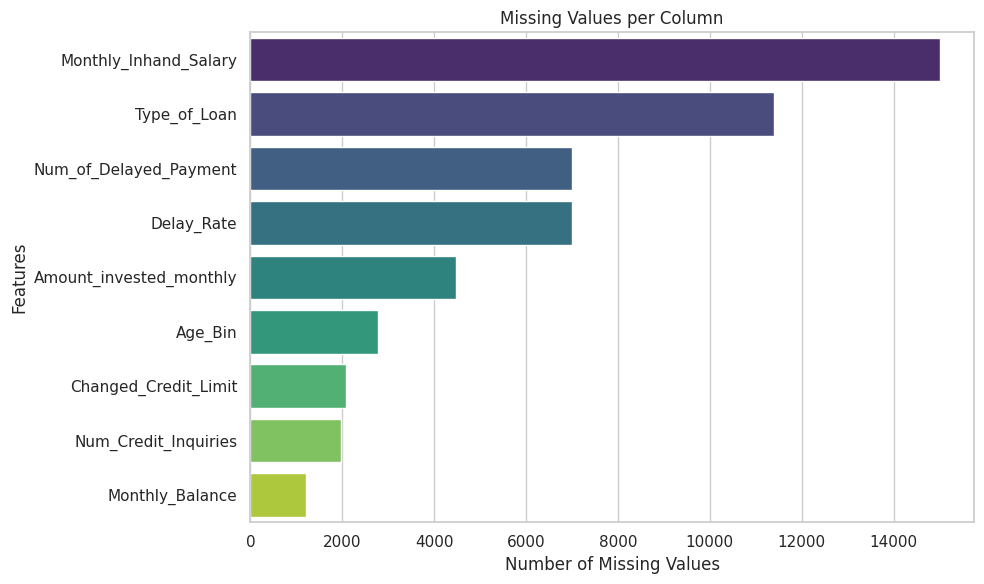

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Missing Values Bar Plot
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.values, y=missing_values.index, palette="viridis")
plt.title("Missing Values per Column")
plt.xlabel("Number of Missing Values")
plt.ylabel("Features")
plt.tight_layout()
plt.show()



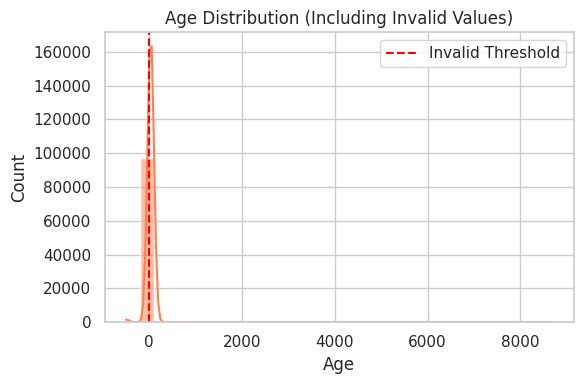

In [8]:
# 2. Age Distribution (Highlighting Invalid)
df['Age_numeric'] = pd.to_numeric(df['Age'], errors='coerce')
plt.figure(figsize=(6, 4))
sns.histplot(df['Age_numeric'], bins=30, kde=True, color='coral')
plt.axvline(0, color='red', linestyle='--', label='Invalid Threshold')
plt.title("Age Distribution (Including Invalid Values)")
plt.xlabel("Age")
plt.legend()
plt.tight_layout()
plt.show()

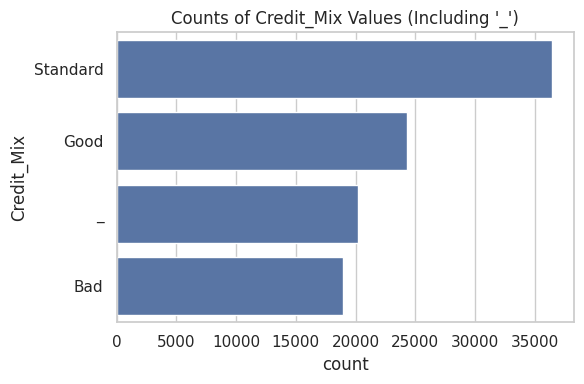

In [9]:
# Placeholder Values in 'Credit_Mix'
plt.figure(figsize=(6, 4))
sns.countplot(y='Credit_Mix', data=df, order=df['Credit_Mix'].value_counts().index)
plt.title("Counts of Credit_Mix Values (Including '_')")
plt.tight_layout()
plt.show()


<ipython-input-10-e0582eb02a15>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Credit_Score', data=df, palette="Set2")


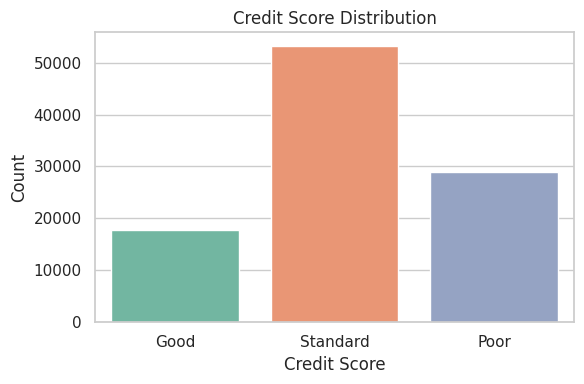

In [10]:
# Target Variable Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Credit_Score', data=df, palette="Set2")
plt.title("Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Feature Correlation Analysis
🧾 What the Code Does (Step-by-Step)

* corr = df.corr(numeric_only=True) -
Computes the Pearson correlation matrix for all numeric columns in the dataset.


* mask = np.triu(np.ones_like(corr, dtype=bool)) - Creates a mask to hide the upper triangle of the correlation matrix for a cleaner, non-redundant heatmap.

* sns.heatmap(corr, annot=True, mask=mask, fmt=".0%", annot_kws={"size":10})
 - Plots a heatmap of the correlations.

* annot=True - shows values in the cells

* fmt=".0%" - formats numbers as percentages

* annot_kws={"size":10} - sets annotation font size

* plt.title("Correlation Matrix") and plt.show() -
Sets a title and renders the plot.


### How to Interpret the Results
Color Intensity:

* Darker red = higher positive correlation (+1)

* Darker purple/black = stronger negative correlation (–1)

* White/near 0 = weak/no correlation

* Diagonal = 100% (each feature is perfectly correlated with itself — always 1)

### Key Insights from the Plot
Strong Correlations:

* Log_Income vs Income_per_Loan: 0.75

* Log_Debt vs Outstanding_Debt: 0.82

* Debt_to_Income vs Credit_Utilization_Ratio: 0.70

### Weak or No Correlation:

* Many features like Num_Bank_Accounts, Num_Credit_Card, etc., show ~0% correlation with most others → likely independent or non-linear relationships.

### Negative Correlation Example:

* Age_Bin vs Annual_Income: –0.96 — as age bin increases, income generally decreases in this dataset.

We computed Person correlation among numeric features to detect linear dependencies. As visualized, most features are weakly correlated, indicating high feature independence. However, a few pairs like Log_Debt and Outstanding_Debt show strong correlation, which may lead to multicollinearity. These insights are critical for model interpretability and feature selection.

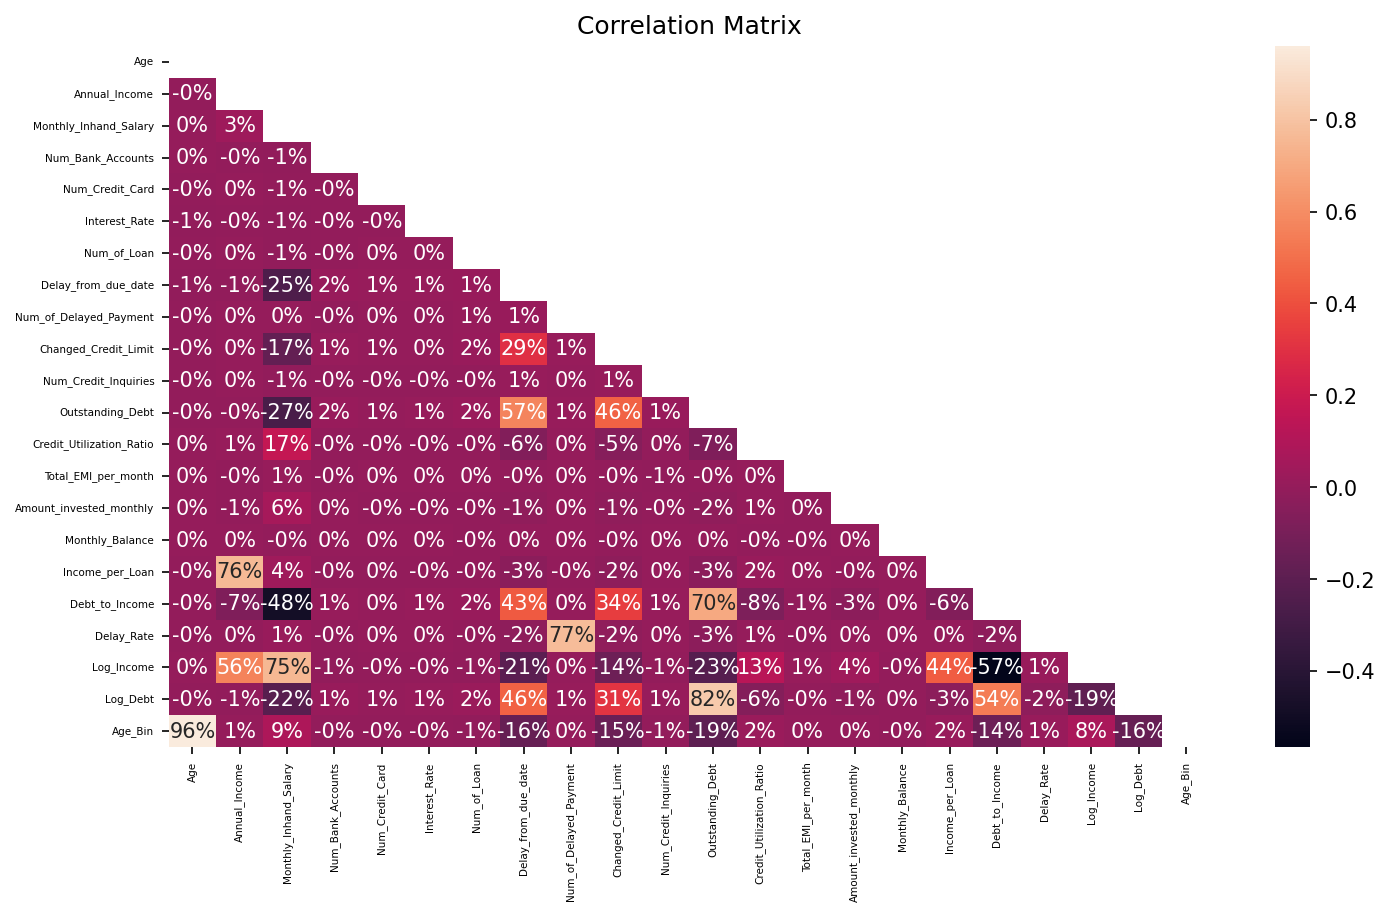

In [ ]:
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

fig = plt.figure(figsize=(10, 6), dpi=150)

sns.heatmap(corr, annot=True, mask=mask, fmt=".0%", annot_kws={"size":10})
plt.grid(False)
plt.tick_params(axis="both", labelsize=5)
plt.tight_layout()
plt.title("Correlation Matrix")
plt.show()

In [ ]:

X = df.drop(columns=["Credit_Score"])
y = df["Credit_Score"]

categorical_cols = X.select_dtypes(include="object").columns.tolist()
numeric_cols = X.select_dtypes(include=["float64", "int64"]).columns

X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
for col in categorical_cols:
    X[col] = X[col].fillna("Unknown")


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
model = CatBoostClassifier(verbose=100, random_state=42, cat_features=categorical_cols)
model.fit(X_train, y_train)


Learning rate set to 0.098942
0:	learn: 1.0348831	total: 450ms	remaining: 7m 29s
100:	learn: 0.5737868	total: 31.8s	remaining: 4m 43s
200:	learn: 0.5538888	total: 1m 4s	remaining: 4m 15s
300:	learn: 0.5416763	total: 1m 36s	remaining: 3m 44s
400:	learn: 0.5313112	total: 2m 7s	remaining: 3m 10s
500:	learn: 0.5220053	total: 2m 39s	remaining: 2m 38s
600:	learn: 0.5145715	total: 3m 10s	remaining: 2m 6s
700:	learn: 0.5073441	total: 3m 41s	remaining: 1m 34s
800:	learn: 0.4997497	total: 4m 13s	remaining: 1m 2s
900:	learn: 0.4926921	total: 4m 44s	remaining: 31.2s
999:	learn: 0.4865729	total: 5m 16s	remaining: 0us


Classification Report:

              precision    recall  f1-score   support

        Good       0.72      0.76      0.74      3566
        Poor       0.78      0.83      0.81      5799
    Standard       0.83      0.78      0.81     10635

    accuracy                           0.79     20000
   macro avg       0.78      0.79      0.78     20000
weighted avg       0.80      0.79      0.79     20000



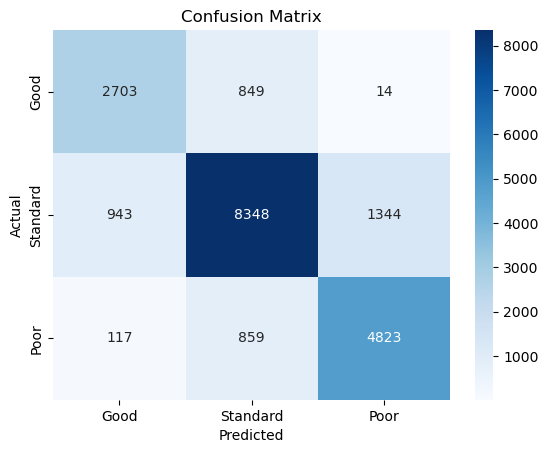

In [ ]:

y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

labels = ["Good", "Standard", "Poor"]
cm = confusion_matrix(y_test, y_pred, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:

model.get_feature_importance(prettified=True).head(10)


,Feature Id,Importances
0,Type_of_Loan,20.600177
1,Occupation,8.666125
2,Credit_Mix,6.417692
3,Outstanding_Debt,5.520582
4,Log_Debt,5.386817
5,Delay_from_due_date,5.295724
6,Interest_Rate,5.284173
7,Total_EMI_per_month,4.472970
8,Num_Credit_Card,4.389603
9,Changed_Credit_Limit,4.046671


## Evaluating Model Stability with CatBoost Cross-Validation to evaluate the model's ability to generalize across unseen data and interpreting the result.

Purpose: Evaluate model stability and generalization using 2-fold stratified CV.

Data Handling: Used Pool() to include categorical features directly.

CV Process: Trained for 300 iterations; tested on alternating folds.

Metric Used: Multi-class log loss (MultiClass objective).

### Best Results:

Fold 0: Best test loss = 0.569

Fold 1: Best test loss = 0.574

Both at final iteration → model still improving.

### Result Interpretation:

No overfitting detected.

Cross-validated results suggest more iterations could improve accuracy.

In [ ]:
from catboost import Pool, cv

pool = Pool(X, y, cat_features=categorical_cols)
params = {"iterations": 300, "loss_function": "MultiClass", "verbose": 0}
cv_result = cv(pool, params, fold_count=2, stratified=True, partition_random_seed=42, verbose=False)

print("Available columns:", cv_result.columns.tolist())


Training on fold [0/2]

bestTest = 0.5693654739
bestIteration = 299

Training on fold [1/2]

bestTest = 0.5738928591
bestIteration = 299

Available columns: ['iterations', 'test-MultiClass-mean', 'test-MultiClass-std', 'train-MultiClass-mean', 'train-MultiClass-std']


## LGBM

In [ ]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [ ]:
import lightgbm as lgb

# Convert categorical columns to category dtype so, the model will not treat this columns as numerical.
for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

model2 = lgb.LGBMClassifier()
model2.fit(X_train, y_train)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11228
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 27
[LightGBM] [Info] Start training from score -1.724428
[LightGBM] [Info] Start training from score -1.237917
[LightGBM] [Info] Start training from score -0.631605


LGBMClassifier()

Classification Report:

              precision    recall  f1-score   support

        Good       0.70      0.72      0.71      3566
        Poor       0.79      0.77      0.78      5799
    Standard       0.80      0.80      0.80     10635

    accuracy                           0.78     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.78      0.78      0.78     20000



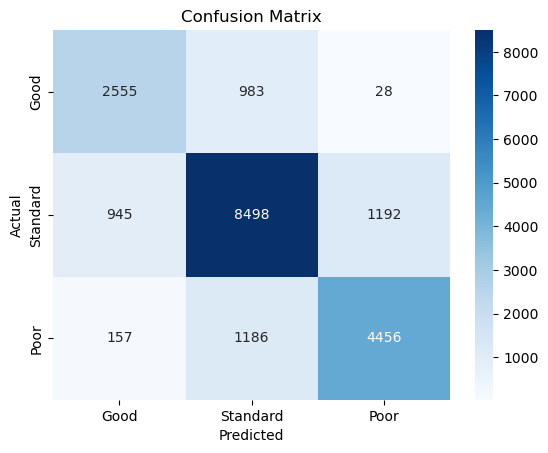

In [ ]:

y_pred2 = model2.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred2))

labels = ["Good", "Standard", "Poor"]
cm = confusion_matrix(y_test, y_pred2, labels=labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Confusion Matrix comparision of catboost and lgbm and comparision

Hypothetical Scenario: Differentiating Model Choice Across Banks
Bank A: Retail-Focused, High Volume, Diverse Loan Products
Model Chosen: CatBoost

Why CatBoost?

Extensive Use of Categorical Variables:

Bank A collects detailed customer data: Occupation, Type_of_Loan, Credit_Mix, Payment_Behaviour.

CatBoost handles categorical features natively and efficiently — no preprocessing overhead.

High Cardinality in Categorical Features:

E.g., 200+ unique values in “Occupation” or “Loan Types”.

CatBoost avoids overfitting via ordered boosting and target-based encoding.

Consistent Performance Across Classes:

From the results: CatBoost had a macro average F1-score of 0.78, and better Good/Standard class recall, making it ideal for banks needing balanced accuracy across customer segments.

“For a bank with rich customer segmentation and categorical-heavy data pipelines, CatBoost reduces the risk of encoding bias and offers out-of-the-box support with minimal tuning.”

Bank B: Fintech-Driven, Fast Loan Approvals, High Traffic
Model Chosen: ✅ LightGBM

Why LightGBM?

Speed and Scalability:

Bank B operates an online instant-approval platform with thousands of real-time applications.

LightGBM uses hist-based splitting and is optimized for large-scale inference, giving it an edge for real-time predictions.

Consistent Accuracy on Majority Class:

Your model shows 0.80 F1 for "Standard" class (majority).

For Bank B, prioritizing accuracy for the majority of applicants makes business sense.

Low Memory Usage:

LGBM can run efficiently in cloud-hosted environments with limited memory and compute costs.

Presentation Angle:

“For fast-scaling fintechs prioritizing low latency and massive data throughput, LightGBM offers the right trade-off between speed and performance.”

Visual & Report Suggestion

Feature / Need	Bank A (CatBoost)	Bank B (LightGBM)
Nature of Data	High-cardinality categorical	Mostly numeric, low-cardinality categories
Need for fast training	Moderate	Very high
Model interpretability	Medium (supports SHAP)	High (excellent SHAP support)
Real-time inference requirement	Low-to-moderate	High (LightGBM is optimized for this)
F1-score for minority classes	Better (Good/Poor) balance	Slightly skewed towards “Standard” class
Deployment Environment	In-house data science team with pipelines	Cloud-based, CI/CD-driven ML workflows


“While CatBoost excels in interpretability and categorical feature handling — making it perfect for customer-segmentation-heavy banks — LightGBM shines in environments requiring rapid model training and real-time scoring. We see a split in adoption based on operational priorities.”

CatBoost Classification Report:

              precision    recall  f1-score   support

        Good       0.72      0.76      0.74      3566
        Poor       0.78      0.83      0.81      5799
    Standard       0.83      0.78      0.81     10635

    accuracy                           0.79     20000
   macro avg       0.78      0.79      0.78     20000
weighted avg       0.80      0.79      0.79     20000


LGBM Classification Report:

              precision    recall  f1-score   support

        Good       0.70      0.72      0.71      3566
        Poor       0.79      0.77      0.78      5799
    Standard       0.80      0.80      0.80     10635

    accuracy                           0.78     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.78      0.78      0.78     20000



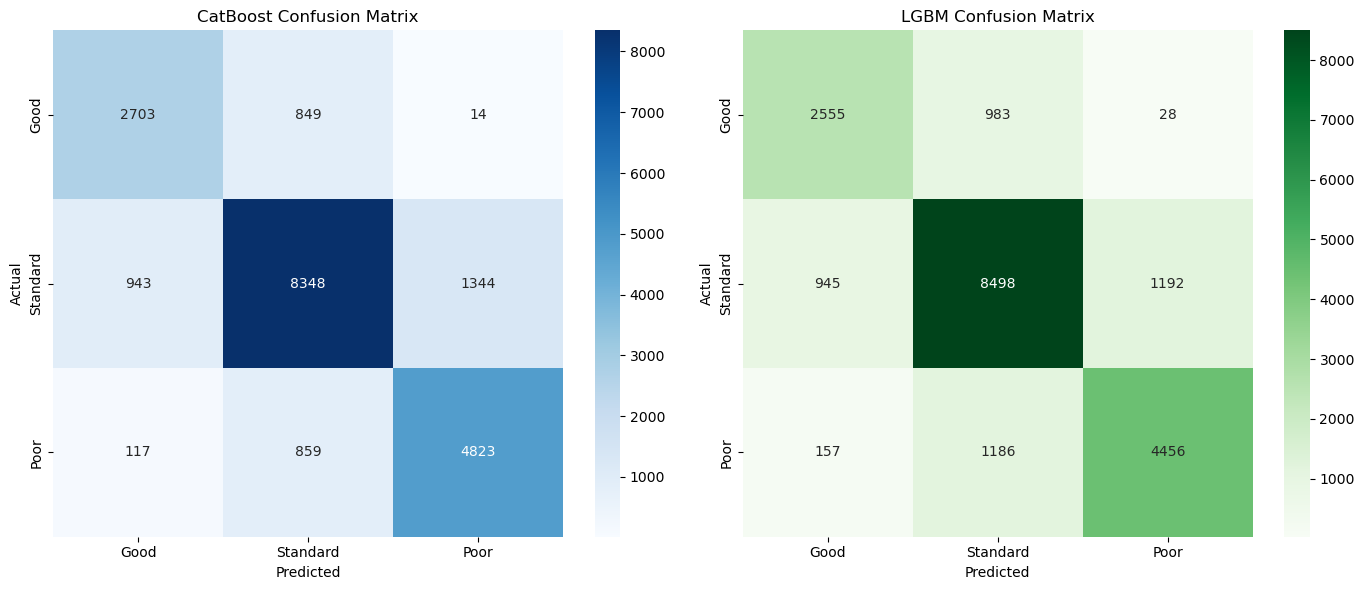

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Define class labels
labels = ["Good", "Standard", "Poor"]

# Print reports
print("CatBoost Classification Report:\n")
print(classification_report(y_test, y_pred))
print("\nLGBM Classification Report:\n")
print(classification_report(y_test, y_pred2))

# Generate confusion matrices
cm1 = confusion_matrix(y_test, y_pred, labels=labels)
cm2 = confusion_matrix(y_test, y_pred2, labels=labels)

# Plot side-by-side confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axs[0])
axs[0].set_title("CatBoost Confusion Matrix")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")

sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels, ax=axs[1])
axs[1].set_title("LGBM Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [ ]:
model.save_model("credit_model.cbm")

Future Implementations: We can deploy this model via a web application by creating the Web App (e.g., using Flask or FastAPI)
### Frontend Interface
Using HTML/JS or a framework like React to collect user input and call the /predict endpoint.

### Deployment Platforms
Cloud: AWS (EC2/Elastic Beanstalk), Azure, or GCP.

Containers: Docker + Kubernetes.

Low-code Hosting: Streamlit Cloud or Hugging Face Spaces (for simpler UIs).